# 3.2-3.4 Benchmark Trading Strategies

Replication des **Figures 1, 2, et 3** de Zhang (2021)

## Workflow complet:
1. **Charger les données** (PEP vs KO)
2. **Construire le spread** avec le hedge ratio γ
3. **Filtrer avec QMCKF** pour estimer le spread latent
4. **Comparer** spread observé vs filtré
5. **Appliquer les stratégies A, B, C** sur le spread filtré

## Step 1: Setup & Load Data

In [1]:
import sys
from pathlib import Path

# Add src to path
src_path = Path.cwd().parent / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import project modules
from pairs_ssm.data.loaders import load_pair, PairData
from pairs_ssm.data.transforms import compute_spread, estimate_gamma, SpreadData
from pairs_ssm.filtering.mle import fit_model  # MLE estimation
from pairs_ssm.filtering.qmckf import qmc_kalman_filter  # QMCKF from Zhang (2021)
from pairs_ssm.models.params import ModelParams
from pairs_ssm.trading.strategy import (
    strategy_A_signals, 
    strategy_B_signals, 
    strategy_C_signals,
    strategy_C_signals_timevarying,  # For heteroscedastic model (Figure 3b)
    find_trades,      # For Strategy A and C
    find_trades_B,    # For Strategy B
)

print("✓ Modules chargés depuis pairs_ssm")
print("✓ QMCKF (Quasi Monte Carlo Kalman Filter) - Zhang (2021)")

✓ Modules chargés depuis pairs_ssm
✓ QMCKF (Quasi Monte Carlo Kalman Filter) - Zhang (2021)


## Step 2: Load PEP-KO Data & Construct Spread

In [2]:
# Load PEP-KO pair
data_path = Path("../data/dataGQ.xlsx")
if not data_path.exists():
    data_path = Path("data/dataGQ.xlsx")
    
pair_data = load_pair(str(data_path), "PEP US Equity", "KO US Equity")

# PairData has PA and PB for raw prices
print(f"Date range: {pair_data.PA.index[0]} to {pair_data.PA.index[-1]}")
print(f"Observations: {len(pair_data.PA)}")

# Construct spread: S_t = log(PEP) - γ * log(KO)
spread_data = compute_spread(pair_data, method="ols", use_log=True)

print(f"\nHedge ratio γ = {spread_data.gamma:.4f}")
print(f"Spread mean = {spread_data.mean:.6f}")
print(f"Spread std  = {spread_data.std:.6f}")

Date range: 2000-01-03 00:00:00 to 2025-12-31 00:00:00
Observations: 6539

Hedge ratio γ = 1.1476
Spread mean = 0.304178
Spread std  = 0.162461


## Step 3: Estimate Model Parameters & Filter with QMCKF

**Model (1)**: $P_{A,t} = \lambda + \gamma P_{B,t} + x_t + \varepsilon_t$ (observation)  
**Model (2)**: $x_{t+1} = f(x_t; \theta) + g(x_t; \theta) \cdot \eta_t$ (state transition)

**Workflow (comme dans Zhang 2021):**
1. Estimer les paramètres θ par **Maximum Likelihood** (MLE)
2. Filtrer le spread avec **QMCKF** (Quasi Monte Carlo Kalman Filter)

In [3]:
# Step 3a: Estimate Model I parameters by Maximum Likelihood
result = fit_model(spread_data.spread, model_type="model_I", method="Nelder-Mead", verbose=True)

# Extract MLE-estimated parameters
params = result.params
print("\n📊 Estimated parameters (MLE):")
print(f"  θ₀ (intercept)      = {params.theta0:.6f}")
print(f"  θ₁ (mean-reversion) = {params.theta1:.6f}")
print(f"  σ²_η (state noise)  = {params.q_base:.8f}")
print(f"  σ²_ε (obs. noise)   = {params.r:.8f}")
print(f"\nLog-likelihood: {result.loglik:.2f}")


📊 Estimated parameters (MLE):
  θ₀ (intercept)      = 0.001150
  θ₁ (mean-reversion) = 0.996379
  σ²_η (state noise)  = 0.00015488
  σ²_ε (obs. noise)   = 0.00000029

Log-likelihood: 19388.97


In [4]:
# Step 3b: Apply QMCKF (Quasi Monte Carlo Kalman Filter) - as in Zhang (2021)
y_arr = spread_data.spread.values

# Run QMCKF with estimated parameters
loglik_qmckf, x_filt_qmckf, x_pred_qmckf, P_filt_qmckf, P_pred_qmckf = qmc_kalman_filter(
    y=y_arr,
    params=params,
    n_particles=500,  # Number of QMC particles
    seed=42
)

# Create filtered spread series
filtered_spread = pd.Series(x_filt_qmckf, index=spread_data.spread.index, name="filtered_qmckf")
observed_spread = spread_data.spread

print("📊 QMCKF Results:")
print(f"  Log-likelihood (QMCKF): {loglik_qmckf:.2f}")
print(f"  Filtered spread mean:   {filtered_spread.mean():.6f}")
print(f"  Filtered spread std:    {filtered_spread.std():.6f}")
print(f"\n✓ Spread filtré avec QMCKF (500 particles) - méthode de Zhang (2021)")

/workspaces/Gestion-Quantitative/pairs-ssm/src/pairs_ssm/filtering/qmckf.py:98: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  points = sampler.random(n_points).flatten()


📊 QMCKF Results:
  Log-likelihood (QMCKF): -130642.80
  Filtered spread mean:   0.304101
  Filtered spread std:    0.162560

✓ Spread filtré avec QMCKF (500 particles) - méthode de Zhang (2021)


## Step 4: Compare Observed vs Filtered Spread

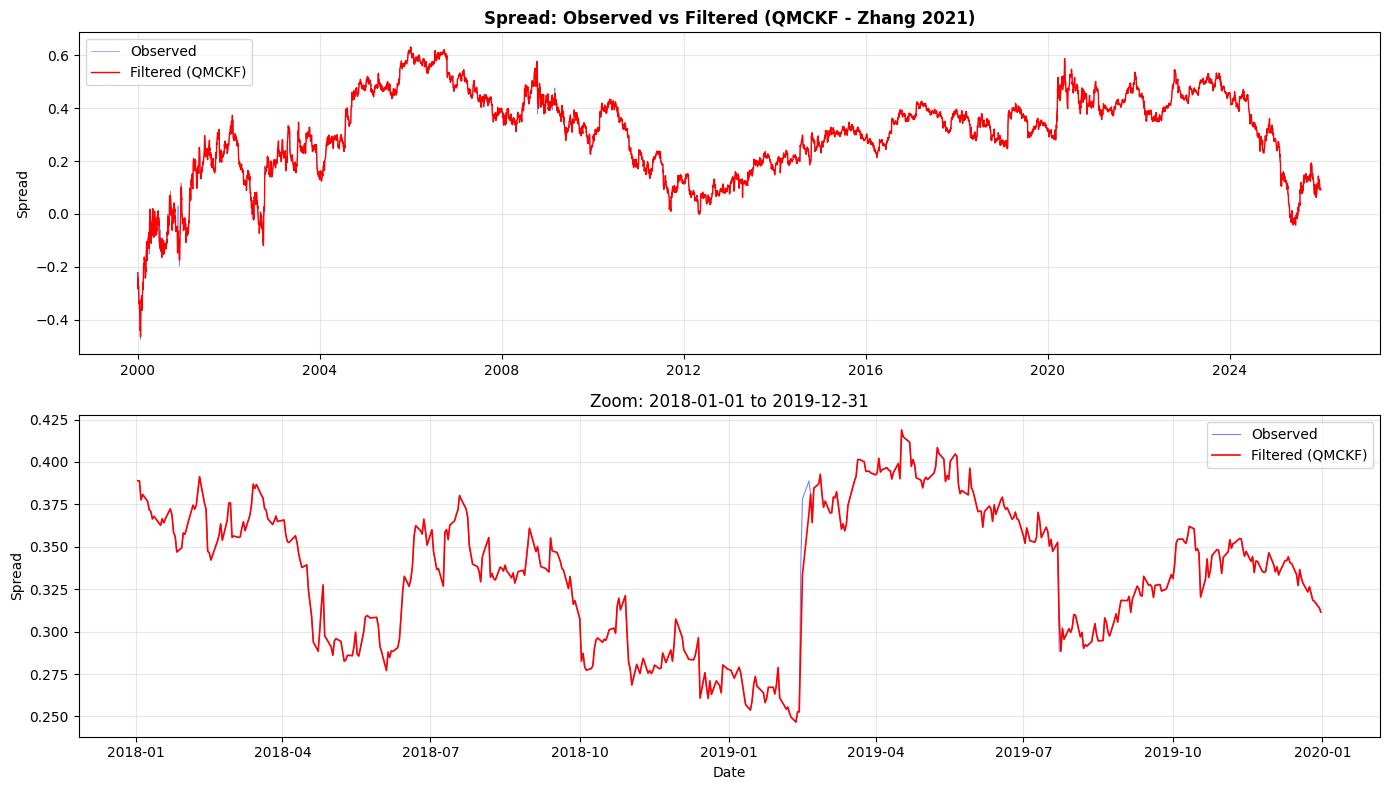


✓ Le QMCKF utilise des séquences quasi-Monte Carlo (Sobol) pour une meilleure couverture de l'espace d'état


In [5]:
# Plot observed vs QMCKF filtered spread
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Top: Full comparison
ax = axes[0]
ax.plot(observed_spread.index, observed_spread.values, 'b-', alpha=0.5, linewidth=0.5, label='Observed')
ax.plot(filtered_spread.index, filtered_spread.values, 'r-', linewidth=1.0, label='Filtered (QMCKF)')
ax.set_title('Spread: Observed vs Filtered (QMCKF - Zhang 2021)', fontsize=12, fontweight='bold')
ax.set_ylabel('Spread')
ax.legend()
ax.grid(True, alpha=0.3)

# Bottom: Zoom on a section
ax = axes[1]
zoom_start = '2018-01-01'
zoom_end = '2019-12-31'
mask = (observed_spread.index >= zoom_start) & (observed_spread.index <= zoom_end)
ax.plot(observed_spread[mask].index, observed_spread[mask].values, 'b-', alpha=0.5, linewidth=0.8, label='Observed')
ax.plot(filtered_spread[mask].index, filtered_spread[mask].values, 'r-', linewidth=1.2, label='Filtered (QMCKF)')
ax.set_title(f'Zoom: {zoom_start} to {zoom_end}', fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Spread')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Le QMCKF utilise des séquences quasi-Monte Carlo (Sobol) pour une meilleure couverture de l'espace d'état")

## Step 5: Define Thresholds U, L, C

Les seuils sont définis en fonction de σ (écart-type du spread filtré)

In [6]:
# Define thresholds based on spread statistics
mu = filtered_spread.mean()
sigma = filtered_spread.std()

# Standard 1-sigma rule (can be optimized later)
k = 1.0  # Number of standard deviations
U = mu + k * sigma  # Upper threshold
L = mu - k * sigma  # Lower threshold
C = mu              # Mean (exit level)

print(f"Spread statistics:")
print(f"  μ (mean) = {mu:.6f}")
print(f"  σ (std)  = {sigma:.6f}")
print(f"\nThresholds ({k}σ rule):")
print(f"  U = μ + {k}σ = {U:.6f}")
print(f"  L = μ - {k}σ = {L:.6f}")
print(f"  C = μ      = {C:.6f}")

Spread statistics:
  μ (mean) = 0.304101
  σ (std)  = 0.162560

Thresholds (1.0σ rule):
  U = μ + 1.0σ = 0.466662
  L = μ - 1.0σ = 0.141541
  C = μ      = 0.304101


## Figure 1: Trading Strategy A

**Strategy A**: Open when spread ≥ U or ≤ L, close when spread returns to mean C

In [7]:
# Apply Strategy A on filtered spread
signals_A = strategy_A_signals(filtered_spread, U=U, L=L, C=C)

# Find trades using module function
trades_A = find_trades(signals_A)
print(f"Strategy A: {len(trades_A)} completed trades")
print(f"  Short trades: {sum(1 for t in trades_A if t['type'] == 'short')}")
print(f"  Long trades:  {sum(1 for t in trades_A if t['type'] == 'long')}")

Strategy A: 6 completed trades
  Short trades: 2
  Long trades:  4


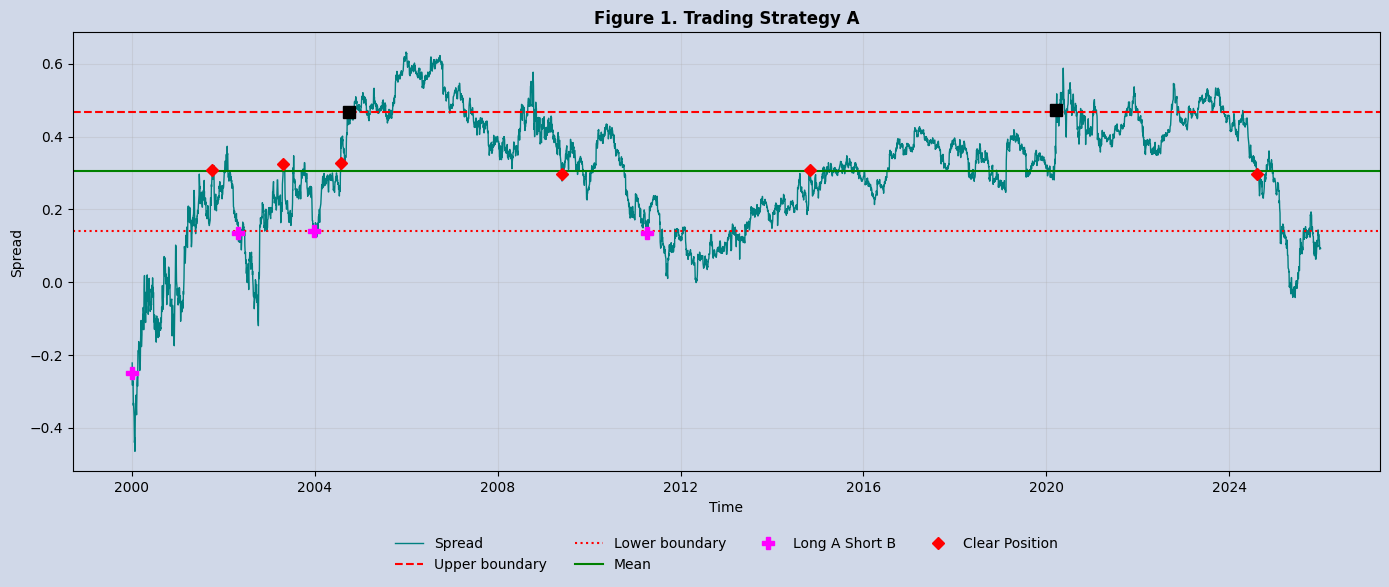

In [8]:
# Plot Figure 1: Strategy A (avec légende du papier)
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#d0d8e8')
ax.set_facecolor('#d0d8e8')

# Plot spread
ax.plot(filtered_spread.index, filtered_spread.values, 'teal', linewidth=1, label='Spread')

# Plot thresholds (comme dans le papier)
ax.axhline(y=U, color='red', linestyle='--', linewidth=1.5, label='Upper boundary')
ax.axhline(y=L, color='red', linestyle=':', linewidth=1.5, label='Lower boundary')
ax.axhline(y=C, color='green', linestyle='-', linewidth=1.5, label='Mean')

# Marquer les points d'entrée/sortie avec les symboles du papier
for trade in trades_A[:8]:
    entry_val = filtered_spread.loc[trade['entry']]
    exit_val = filtered_spread.loc[trade['exit']]
    
    if trade['type'] == 'short':
        # ■ Short A Long B (carré noir) - entrée short quand spread > U
        ax.plot(trade['entry'], entry_val, 's', color='black', markersize=8, label='Short A Long B' if trade == trades_A[0] else '')
    else:
        # + Long A Short B (croix magenta) - entrée long quand spread < L
        ax.plot(trade['entry'], entry_val, 'P', color='magenta', markersize=8, label='Long A Short B' if trade == trades_A[0] else '')
    
    # ◆ Clear Position (losange rouge) - sortie à la moyenne
    ax.plot(trade['exit'], exit_val, 'D', color='red', markersize=6, label='Clear Position' if trade == trades_A[0] else '')

ax.set_title('Figure 1. Trading Strategy A', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')

# Légende en bas (comme dans le papier)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, frameon=False)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Figure 2: Trading Strategy B

**Strategy B**: Open when spread *crosses* U from below or L from above

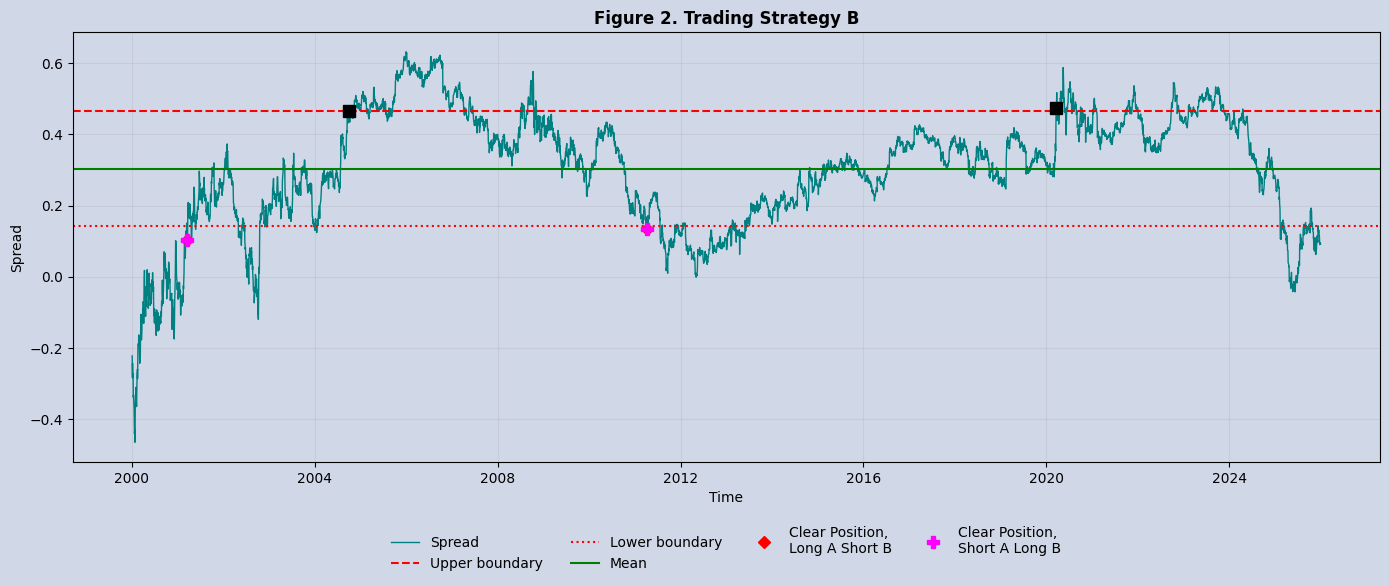

Strategy B: 4 completed trades
  Short trades: 2
  Long trades:  2


In [9]:
# Apply Strategy B
signals_B = strategy_B_signals(filtered_spread, U=U, L=L)

# Find trades using module function (B flips positions directly)
trades_B = find_trades_B(signals_B)

# Plot Figure 2: Strategy B (avec légende du papier)
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#d0d8e8')
ax.set_facecolor('#d0d8e8')

# Plot spread
ax.plot(filtered_spread.index, filtered_spread.values, 'teal', linewidth=1, label='Spread')

# Plot thresholds
ax.axhline(y=U, color='red', linestyle='--', linewidth=1.5, label='Upper boundary')
ax.axhline(y=L, color='red', linestyle=':', linewidth=1.5, label='Lower boundary')
ax.axhline(y=C, color='green', linestyle='-', linewidth=1.5, label='Mean')

# Marquer les points d'entrée/sortie - Strategy B: clear & open coincide
for i, trade in enumerate(trades_B[:8]):
    entry_val = filtered_spread.loc[trade['entry']]
    
    if trade['type'] == 'short':
        # ■ Short A Long B (entrée short = crosse U from below)
        ax.plot(trade['entry'], entry_val, 's', color='black', markersize=8, 
                label='Short A Long B' if i == 0 else '')
    else:
        # ◆ Clear Position, Long A Short B (entrée long = clear short + open long)
        ax.plot(trade['entry'], entry_val, 'D', color='red', markersize=6,
                label='Clear Position,\nLong A Short B' if i == 0 else '')

# Also mark the first long entries with magenta cross
for i, trade in enumerate(trades_B[:8]):
    if trade['type'] == 'long':
        entry_val = filtered_spread.loc[trade['entry']]
        ax.plot(trade['entry'], entry_val, 'P', color='magenta', markersize=8,
                label='Clear Position,\nShort A Long B' if i == 0 else '')

ax.set_title('Figure 2. Trading Strategy B', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')

# Légende en bas
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, frameon=False)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Strategy B: {len(trades_B)} completed trades")
print(f"  Short trades: {sum(1 for t in trades_B if t['type'] == 'short')}")
print(f"  Long trades:  {sum(1 for t in trades_B if t['type'] == 'long')}")

## Figure 3: Trading Strategy C

**Strategy C** (contribution du papier): 
- Entry: spread crosses U **from above** or L **from below**
- Exit: crosses mean C or stop-loss at boundary

Strategy C: 104 completed trades
  Short trades (spread came down from above U): 63
  Long trades (spread came up from below L):    41

  First short trade: entry=2004-10-04 00:00:00, exit=2004-10-18 00:00:00
  First long trade:  entry=2001-03-14 00:00:00, exit=2001-03-16 00:00:00


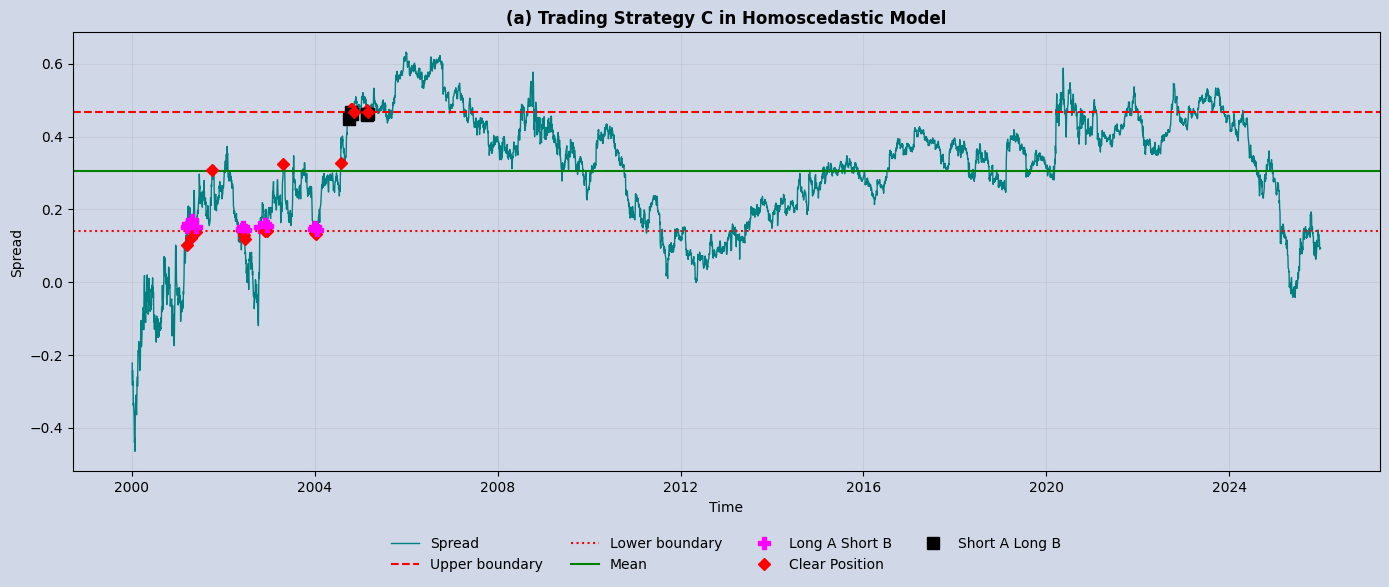

In [10]:
# Apply Strategy C
signals_C = strategy_C_signals(filtered_spread, U=U, L=L, C=C)
trades_C = find_trades(signals_C)

# Debug: show breakdown of trades
short_trades_C = [t for t in trades_C if t['type'] == 'short']
long_trades_C = [t for t in trades_C if t['type'] == 'long']
print(f"Strategy C: {len(trades_C)} completed trades")
print(f"  Short trades (spread came down from above U): {len(short_trades_C)}")
print(f"  Long trades (spread came up from below L):    {len(long_trades_C)}")

# Show first few of each type
if short_trades_C:
    print(f"\n  First short trade: entry={short_trades_C[0]['entry']}, exit={short_trades_C[0]['exit']}")
if long_trades_C:
    print(f"  First long trade:  entry={long_trades_C[0]['entry']}, exit={long_trades_C[0]['exit']}")

# Plot Figure 3: Strategy C in Homoscedastic Model (avec légende du papier)
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#d0d8e8')
ax.set_facecolor('#d0d8e8')

# Plot spread
ax.plot(filtered_spread.index, filtered_spread.values, 'teal', linewidth=1, label='Spread')

# Plot thresholds
ax.axhline(y=U, color='red', linestyle='--', linewidth=1.5, label='Upper boundary')
ax.axhline(y=L, color='red', linestyle=':', linewidth=1.5, label='Lower boundary')
ax.axhline(y=C, color='green', linestyle='-', linewidth=1.5, label='Mean')

# Plot ALL trades (not just first 8) but limit markers for readability
n_trades_to_show = min(20, len(trades_C))
shown_short = False
shown_long = False
shown_clear = False

for trade in trades_C[:n_trades_to_show]:
    entry_val = filtered_spread.loc[trade['entry']]
    exit_val = filtered_spread.loc[trade['exit']]
    
    if trade['type'] == 'short':
        # ■ Short A Long B (carré noir) - entrée short quand spread revient sous U
        ax.plot(trade['entry'], entry_val, 's', color='black', markersize=8, 
                label='Short A Long B' if not shown_short else '')
        shown_short = True
    else:
        # + Long A Short B (croix magenta) - entrée long quand spread remonte au-dessus de L
        ax.plot(trade['entry'], entry_val, 'P', color='magenta', markersize=8, 
                label='Long A Short B' if not shown_long else '')
        shown_long = True
    
    # ◆ Clear Position (sortie à la moyenne C ou stop-loss)
    ax.plot(trade['exit'], exit_val, 'D', color='red', markersize=6, 
            label='Clear Position' if not shown_clear else '')
    shown_clear = True

ax.set_title('(a) Trading Strategy C in Homoscedastic Model', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')

# Légende en bas
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, frameon=False)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

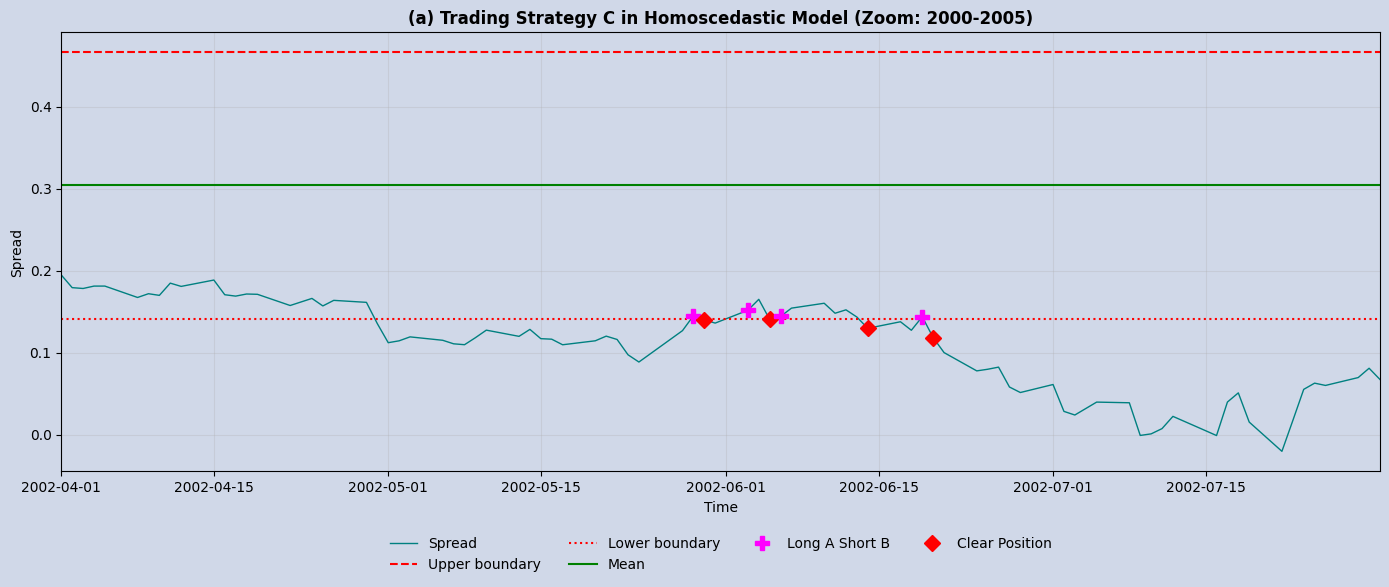


Trades dans la période 2000-2005: 4
  Short: 0
  Long:  4


In [11]:
# Zoom sur 2000-2005 pour Strategy C
zoom_start_C = '2002-04-01'
zoom_end_C = '2002-07-31'

fig, ax = plt.subplots(figsize=(14, 6), facecolor='#d0d8e8')
ax.set_facecolor('#d0d8e8')

# Filter data for zoom period
mask_zoom = (filtered_spread.index >= zoom_start_C) & (filtered_spread.index <= zoom_end_C)
spread_zoom = filtered_spread[mask_zoom]

# Plot spread
ax.plot(spread_zoom.index, spread_zoom.values, 'teal', linewidth=1, label='Spread')

# Plot thresholds
ax.axhline(y=U, color='red', linestyle='--', linewidth=1.5, label='Upper boundary')
ax.axhline(y=L, color='red', linestyle=':', linewidth=1.5, label='Lower boundary')
ax.axhline(y=C, color='green', linestyle='-', linewidth=1.5, label='Mean')

# Filter trades in this period
trades_in_period = [t for t in trades_C if t['entry'] >= pd.Timestamp(zoom_start_C) and t['entry'] <= pd.Timestamp(zoom_end_C)]

shown_short = False
shown_long = False
shown_clear = False

for trade in trades_in_period:
    entry_val = filtered_spread.loc[trade['entry']]
    exit_val = filtered_spread.loc[trade['exit']]
    
    if trade['type'] == 'short':
        ax.plot(trade['entry'], entry_val, 's', color='black', markersize=10, 
                label='Short A Long B' if not shown_short else '')
        shown_short = True
    else:
        ax.plot(trade['entry'], entry_val, 'P', color='magenta', markersize=10, 
                label='Long A Short B' if not shown_long else '')
        shown_long = True
    
    ax.plot(trade['exit'], exit_val, 'D', color='red', markersize=8, 
            label='Clear Position' if not shown_clear else '')
    shown_clear = True

ax.set_title('(a) Trading Strategy C in Homoscedastic Model (Zoom: 2000-2005)', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')
ax.set_xlim(pd.Timestamp(zoom_start_C), pd.Timestamp(zoom_end_C))

# Légende en bas
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, frameon=False)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTrades dans la période 2000-2005: {len(trades_in_period)}")
print(f"  Short: {sum(1 for t in trades_in_period if t['type'] == 'short')}")
print(f"  Long:  {sum(1 for t in trades_in_period if t['type'] == 'long')}")


# A partir d'ici, on passe au modèle heteroscedastique en prennant le modèle 3 du papier (page 7) pour la selection de U et L

## Figure 3(b): Trading Strategy C in Heteroscedastic Model

Dans le modèle hétéroscédastique (Model 3 du papier), la fonction de volatilité $g(x)$ dépend de l'état:
$$g(x_t) = \sqrt{q_{base} + q_{het} \cdot x_t^2}$$

Les **boundaries U et L varient dans le temps** en fonction de cette volatilité conditionnelle:
$$U_t = \mu + k \cdot g(x_t), \quad L_t = \mu - k \cdot g(x_t)$$

**Note**: Les données réelles PEP-KO sont quasi-homoscédastiques ($q_{het} \approx 0$). Pour illustrer l'effet des boundaries time-varying, nous utilisons le **Model 3** du papier avec des paramètres simulés.

In [12]:
# Pour illustrer Figure 3(b), on utilise le Model 3 du papier (hétéroscédastique)
# Model 3: x_{t+1} = 0.9590 * x_t + sqrt(0.00089 + 0.08 * x_t^2) * η_t
print("=" * 60)
print("MODEL 3 (Heteroscedastic) - From Zhang (2021) Section 3.5")
print("=" * 60)
print("\nModel 3 parameters:")
print("  x_{t+1} = 0.9590 * x_t + sqrt(0.00089 + 0.08 * x_t^2) * η_t")
print("  θ₁ = 0.9590 (mean-reversion)")
print("  q_base = 0.00089")
print("  q_het = 0.08")
print("\nNote: Real PEP-KO data is quasi-homoscedastic (q_het ≈ 0)")
print("Using Model 3 parameters to illustrate time-varying boundaries.")

MODEL 3 (Heteroscedastic) - From Zhang (2021) Section 3.5

Model 3 parameters:
  x_{t+1} = 0.9590 * x_t + sqrt(0.00089 + 0.08 * x_t^2) * η_t
  θ₁ = 0.9590 (mean-reversion)
  q_base = 0.00089
  q_het = 0.08

Note: Real PEP-KO data is quasi-homoscedastic (q_het ≈ 0)
Using Model 3 parameters to illustrate time-varying boundaries.


In [13]:
# Use filtered spread from Model I (homoscedastic) but apply Model 3 g(x) function
# for time-varying boundaries illustration

# Model 3 parameters from paper
q_base_m3 = 0.00089
q_het_m3 = 0.08

# Compute g(x_t) = sqrt(q_base + q_het * x_t^2) for each filtered state
# Note: x_t should be demeaned for this to work properly
x_demeaned = filtered_spread - filtered_spread.mean()
g_t = np.sqrt(q_base_m3 + q_het_m3 * x_demeaned**2)
g_t_series = pd.Series(g_t, index=filtered_spread.index, name="g_t")

print("📊 Volatility g(x_t) = sqrt(q_base + q_het * x_t^2):")
print(f"  g_t mean: {g_t_series.mean():.6f}")
print(f"  g_t std:  {g_t_series.std():.6f}")
print(f"  g_t min:  {g_t_series.min():.6f}")
print(f"  g_t max:  {g_t_series.max():.6f}")
print("\n→ g(x) varies with the spread level (heteroscedasticity)")

📊 Volatility g(x_t) = sqrt(q_base + q_het * x_t^2):
  g_t mean: 0.050008
  g_t std:  0.022427
  g_t min:  0.029833
  g_t max:  0.219529

→ g(x) varies with the spread level (heteroscedasticity)


In [14]:
# Compute TIME-VARYING boundaries based on g(x_t)
# U_t = μ + k * g(x_t),  L_t = μ - k * g(x_t)
mu_het = filtered_spread.mean()
k_het = 1.0  # Number of g(x) multiples (similar to σ rule)

# Scale g_t to match spread scale (paper uses different normalization)
# We scale so that average boundary width matches homoscedastic case
scale_factor = sigma / g_t_series.mean()
g_t_scaled = g_t_series * scale_factor

# Time-varying boundaries
U_t = mu_het + k_het * g_t_scaled  # Upper boundary varies with volatility
L_t = mu_het - k_het * g_t_scaled  # Lower boundary varies with volatility
C_het = mu_het  # Mean (constant)

print(f"Time-varying thresholds (k={k_het} × g(x) rule):")
print(f"  U_t range: [{U_t.min():.4f}, {U_t.max():.4f}]")
print(f"  L_t range: [{L_t.min():.4f}, {L_t.max():.4f}]")
print(f"  C (mean):  {C_het:.4f}")
print(f"\n  Scale factor: {scale_factor:.4f}")
print("\n→ Boundaries expand when spread is far from mean (high volatility)")
print("→ Boundaries contract when spread is near mean (low volatility)")

Time-varying thresholds (k=1.0 × g(x) rule):
  U_t range: [0.4011, 1.0177]
  L_t range: [-0.4095, 0.2071]
  C (mean):  0.3041

  Scale factor: 3.2507

→ Boundaries expand when spread is far from mean (high volatility)
→ Boundaries contract when spread is near mean (low volatility)


In [15]:
# Apply Strategy C with TIME-VARYING boundaries (from module)
signals_C_het = strategy_C_signals_timevarying(filtered_spread, U_t, L_t, C_het)
trades_C_het = find_trades(signals_C_het)

print(f"Strategy C (Heteroscedastic Model 3): {len(trades_C_het)} completed trades")
print(f"  Short trades: {sum(1 for t in trades_C_het if t['type'] == 'short')}")
print(f"  Long trades:  {sum(1 for t in trades_C_het if t['type'] == 'long')}")

Strategy C (Heteroscedastic Model 3): 30 completed trades
  Short trades: 8
  Long trades:  22


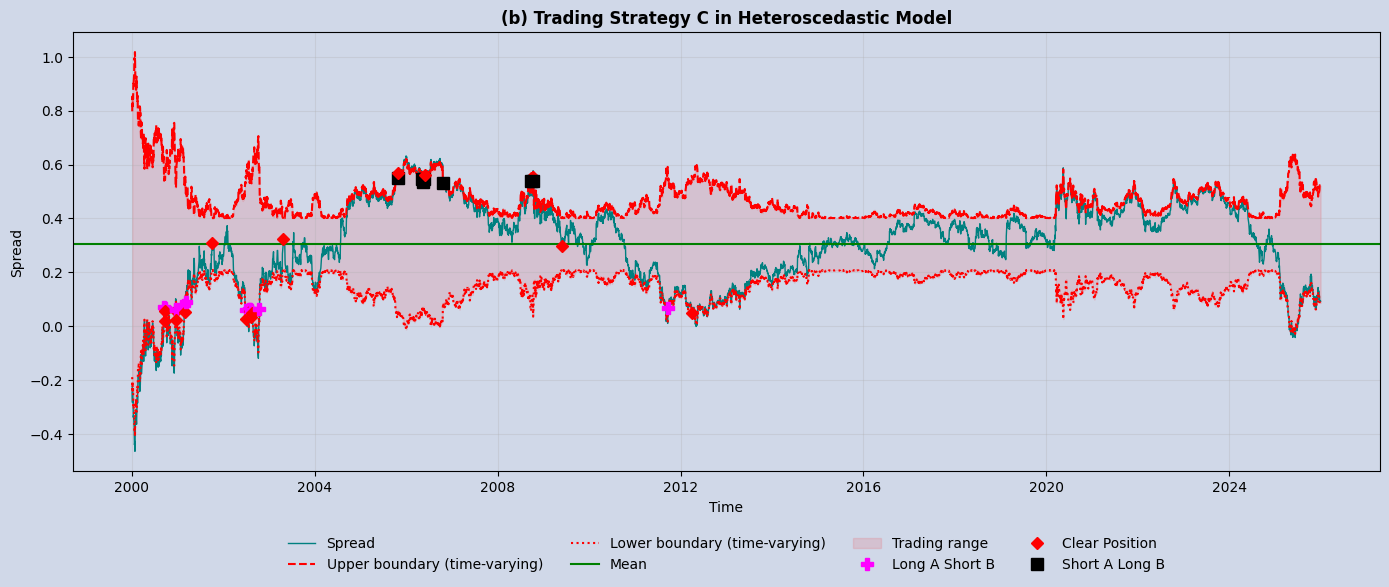

In [16]:
# Plot Figure 3(b): Strategy C in Heteroscedastic Model
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#d0d8e8')
ax.set_facecolor('#d0d8e8')

# Plot spread
ax.plot(filtered_spread.index, filtered_spread.values, 'teal', linewidth=1, label='Spread')

# Plot TIME-VARYING boundaries (as bands)
ax.plot(U_t.index, U_t.values, 'r--', linewidth=1.5, label='Upper boundary (time-varying)')
ax.plot(L_t.index, L_t.values, 'r:', linewidth=1.5, label='Lower boundary (time-varying)')
ax.axhline(y=C_het, color='green', linestyle='-', linewidth=1.5, label='Mean')

# Fill between boundaries to show time-varying nature
ax.fill_between(U_t.index, L_t.values, U_t.values, alpha=0.1, color='red', label='Trading range')

# Mark trades
n_trades_show = min(20, len(trades_C_het))
shown_short = False
shown_long = False
shown_clear = False

for trade in trades_C_het[:n_trades_show]:
    entry_val = filtered_spread.loc[trade['entry']]
    exit_val = filtered_spread.loc[trade['exit']]
    
    if trade['type'] == 'short':
        ax.plot(trade['entry'], entry_val, 's', color='black', markersize=8, 
                label='Short A Long B' if not shown_short else '')
        shown_short = True
    else:
        ax.plot(trade['entry'], entry_val, 'P', color='magenta', markersize=8, 
                label='Long A Short B' if not shown_long else '')
        shown_long = True
    
    ax.plot(trade['exit'], exit_val, 'D', color='red', markersize=6, 
            label='Clear Position' if not shown_clear else '')
    shown_clear = True

ax.set_title('(b) Trading Strategy C in Heteroscedastic Model', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, frameon=False)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

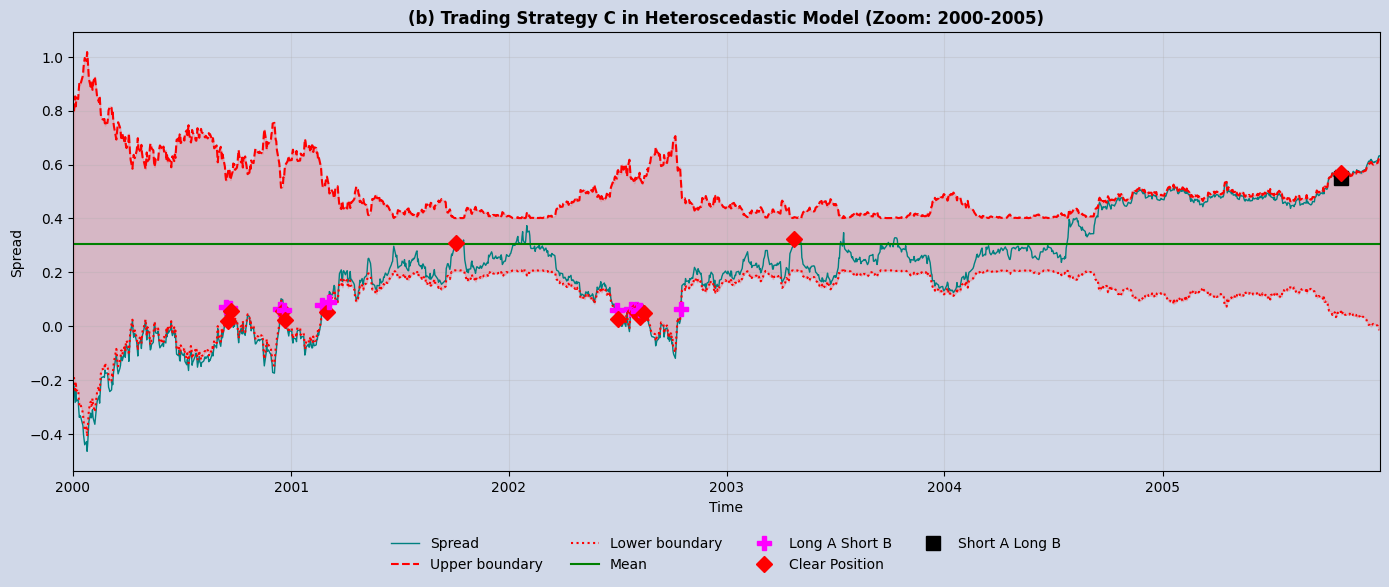


Trades dans la période 2000-2005 (Heteroscedastic): 13
  Short: 1
  Long:  12


In [17]:
# Zoom sur 2000-2005 pour Strategy C Heteroscedastic
zoom_start_het = '2000-01-01'
zoom_end_het = '2005-12-31'

fig, ax = plt.subplots(figsize=(14, 6), facecolor='#d0d8e8')
ax.set_facecolor('#d0d8e8')

# Filter data for zoom
mask_het = (filtered_spread.index >= zoom_start_het) & (filtered_spread.index <= zoom_end_het)

# Plot spread
ax.plot(filtered_spread[mask_het].index, filtered_spread[mask_het].values, 'teal', linewidth=1, label='Spread')

# Plot time-varying boundaries
ax.plot(U_t[mask_het].index, U_t[mask_het].values, 'r--', linewidth=1.5, label='Upper boundary')
ax.plot(L_t[mask_het].index, L_t[mask_het].values, 'r:', linewidth=1.5, label='Lower boundary')
ax.axhline(y=C_het, color='green', linestyle='-', linewidth=1.5, label='Mean')

# Fill trading range
ax.fill_between(U_t[mask_het].index, L_t[mask_het].values, U_t[mask_het].values, alpha=0.15, color='red')

# Filter trades in period
trades_het_period = [t for t in trades_C_het 
                     if t['entry'] >= pd.Timestamp(zoom_start_het) and t['entry'] <= pd.Timestamp(zoom_end_het)]

shown_short = False
shown_long = False
shown_clear = False

for trade in trades_het_period:
    entry_val = filtered_spread.loc[trade['entry']]
    exit_val = filtered_spread.loc[trade['exit']]
    
    if trade['type'] == 'short':
        ax.plot(trade['entry'], entry_val, 's', color='black', markersize=10, 
                label='Short A Long B' if not shown_short else '')
        shown_short = True
    else:
        ax.plot(trade['entry'], entry_val, 'P', color='magenta', markersize=10, 
                label='Long A Short B' if not shown_long else '')
        shown_long = True
    
    ax.plot(trade['exit'], exit_val, 'D', color='red', markersize=8, 
            label='Clear Position' if not shown_clear else '')
    shown_clear = True

ax.set_title('(b) Trading Strategy C in Heteroscedastic Model (Zoom: 2000-2005)', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')
ax.set_xlim(pd.Timestamp(zoom_start_het), pd.Timestamp(zoom_end_het))

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, frameon=False)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTrades dans la période 2000-2005 (Heteroscedastic): {len(trades_het_period)}")
print(f"  Short: {sum(1 for t in trades_het_period if t['type'] == 'short')}")
print(f"  Long:  {sum(1 for t in trades_het_period if t['type'] == 'long')}")

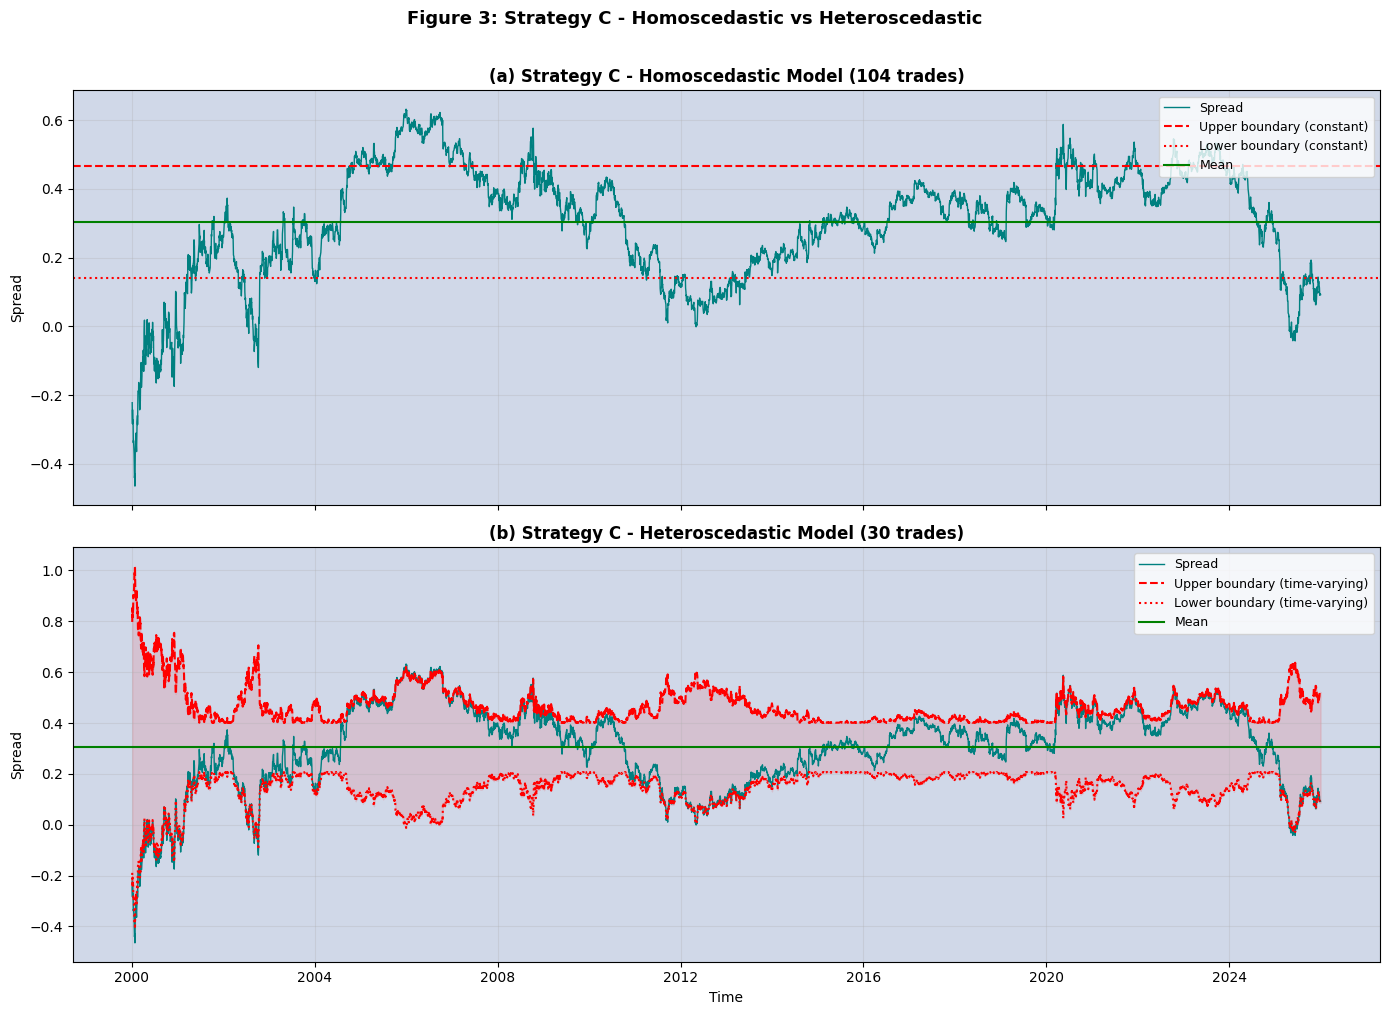


📊 Comparaison Strategy C:
  Homoscedastic:   104 trades (boundaries constantes)
  Heteroscedastic: 30 trades (boundaries time-varying)

💡 Dans le modèle hétéroscédastique (Model 3):
   - g(x) = sqrt(q_base + q_het * x²)
   - Les boundaries s'élargissent quand le spread est loin de la moyenne
   - Les boundaries se resserrent quand le spread est proche de la moyenne


In [18]:
# Comparison: Homoscedastic vs Heteroscedastic Strategy C
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# (a) Homoscedastic
ax = axes[0]
ax.set_facecolor('#d0d8e8')
ax.plot(filtered_spread.index, filtered_spread.values, 'teal', linewidth=1, label='Spread')
ax.axhline(y=U, color='red', linestyle='--', linewidth=1.5, label='Upper boundary (constant)')
ax.axhline(y=L, color='red', linestyle=':', linewidth=1.5, label='Lower boundary (constant)')
ax.axhline(y=C, color='green', linestyle='-', linewidth=1.5, label='Mean')
ax.set_title(f'(a) Strategy C - Homoscedastic Model ({len(trades_C)} trades)', fontsize=12, fontweight='bold')
ax.set_ylabel('Spread')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

# (b) Heteroscedastic
ax = axes[1]
ax.set_facecolor('#d0d8e8')
ax.plot(filtered_spread.index, filtered_spread.values, 'teal', linewidth=1, label='Spread')
ax.plot(U_t.index, U_t.values, 'r--', linewidth=1.5, label='Upper boundary (time-varying)')
ax.plot(L_t.index, L_t.values, 'r:', linewidth=1.5, label='Lower boundary (time-varying)')
ax.fill_between(U_t.index, L_t.values, U_t.values, alpha=0.1, color='red')
ax.axhline(y=C_het, color='green', linestyle='-', linewidth=1.5, label='Mean')
ax.set_title(f'(b) Strategy C - Heteroscedastic Model ({len(trades_C_het)} trades)', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.suptitle('Figure 3: Strategy C - Homoscedastic vs Heteroscedastic', fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\n📊 Comparaison Strategy C:")
print(f"  Homoscedastic:   {len(trades_C)} trades (boundaries constantes)")
print(f"  Heteroscedastic: {len(trades_C_het)} trades (boundaries time-varying)")
print("\n💡 Dans le modèle hétéroscédastique (Model 3):")
print("   - g(x) = sqrt(q_base + q_het * x²)")
print("   - Les boundaries s'élargissent quand le spread est loin de la moyenne")
print("   - Les boundaries se resserrent quand le spread est proche de la moyenne")